In [38]:
!pip install pyspark

In [39]:
!apt-get update
!apt-get install -y openjdk-11-jdk
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Fetched 129 kB in 20s (6,493 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (s

In [40]:
!java -version

openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04)
OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)


In [41]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("IMDB Data Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark

In [42]:
basics_path = "/content/title.basics.tsv"
ratings_path = "/content/title.ratings.tsv"

df_basics = spark.read.csv(
    basics_path,
    sep="\t",
    header=True,
    inferSchema=True
)

df_ratings = spark.read.csv(
    ratings_path,
    sep="\t",
    header=True,
    inferSchema=True
)

df_basics.show(5)
df_ratings.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|        Poor Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|              

In [43]:
df_joined = df_basics.join(df_ratings, on="tconst", how="inner")

df_joined.show(10)
df_joined.printSchema()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|          5.5|     306|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|          5.2|     196|
|tt0000008|    short|Edison Kinetoscop...|Edison Kinetoscop...|      0|     1894|     \N|             1|   Documentary,Short|          5.4|    2357|
|tt0000015|    short|      Around a Cabin| Autour d'une cabine|      0|     1894|     \N|             2|An

In [44]:
from pyspark.sql.functions import col

df_clean = df_final.replace("\\N", None)

df_clean = df_clean \
    .withColumn("startYear", col("startYear").cast("int")) \
    .withColumn("endYear", col("endYear").cast("int")) \
    .withColumn("runtimeMinutes", col("runtimeMinutes").cast("int"))

df_clean.printSchema()

df_clean.show(10)

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|   NU

In [45]:
df_clean.count()

179281

In [46]:
df_top_movies = df_clean.filter(df_clean.numVotes >= 1000) \
    .orderBy(df_clean.averageRating.desc()) \
    .select("primaryTitle", "startYear", "averageRating", "numVotes")

df_top_movies.show(10, truncate=False)

+-------------------------------------------+---------+-------------+--------+
|primaryTitle                               |startYear|averageRating|numVotes|
+-------------------------------------------+---------+-------------+--------+
|The Legend of Zelda: Ocarina of Time       |1998     |9.6          |11612   |
|Metal Gear Solid                           |1998     |9.5          |13985   |
|Final Fantasy VII                          |1997     |9.5          |11921   |
|Radovan III                                |1983     |9.5          |1658    |
|Fallout 2: A Post-Nuclear Role-Playing Game|1998     |9.4          |4580    |
|Band of Brothers                           |2001     |9.4          |579318  |
|The Surrealists' Top Chart                 |1984     |9.4          |1790    |
|Chrono Trigger                             |1995     |9.4          |3535    |
|Baldur's Gate II: Shadows of Amn           |2000     |9.4          |2467    |
|Malgudi Days                               |1986   

In [47]:
from pyspark.sql.functions import split, explode, col, avg

df_genres = df_clean.withColumn("genre", explode(split(col("genres"), ",")))

genre_avg = df_genres.groupBy("genre") \
                     .agg(avg("averageRating").alias("avg_rating")) \
                     .orderBy(col("avg_rating").desc())

genre_avg.show(20, truncate=False)

+-----------+------------------+
|genre      |avg_rating        |
+-----------+------------------+
|Biography  |6.765316455696204 |
|Music      |6.757904445674252 |
|History    |6.75310948214705  |
|Documentary|6.684315286624195 |
|Family     |6.509057463209541 |
|Game-Show  |6.495302013422814 |
|Film-Noir  |6.459137343927357 |
|Animation  |6.456588455705283 |
|War        |6.42423702383603  |
|Talk-Show  |6.3123949579831935|
|Drama      |6.300324000255081 |
|Mystery    |6.216235764850702 |
|Romance    |6.212194990282859 |
|Musical    |6.206943086250728 |
|Fantasy    |6.194288681204553 |
|Sport      |6.191231845077989 |
|Adventure  |6.141621129326081 |
|Crime      |6.139512091189968 |
|Comedy     |6.122424007744443 |
|Reality-TV |6.11916666666667  |
+-----------+------------------+
only showing top 20 rows



In [48]:
from pyspark.sql.functions import count

genre_count = df_genres.groupBy("genre") \
                       .agg(count("*").alias("num_movies")) \
                       .orderBy(col("num_movies").desc())

genre_count.show(20, truncate=False)

+-----------+----------+
|genre      |num_movies|
+-----------+----------+
|Drama      |78395     |
|Comedy     |51650     |
|Short      |21563     |
|Crime      |18774     |
|Romance    |18524     |
|Action     |15683     |
|Adventure  |13176     |
|Documentary|12560     |
|Family     |11416     |
|Animation  |11209     |
|Thriller   |9018      |
|Adult      |8619      |
|Horror     |7232      |
|Mystery    |6498      |
|Fantasy    |5778      |
|Music      |5421      |
|Musical    |5113      |
|Western    |5062      |
|War        |4489      |
|History    |4229      |
+-----------+----------+
only showing top 20 rows



In [49]:
genre_stats = genre_avg.join(genre_count, on="genre") \
                       .orderBy(col("avg_rating").desc())

genre_stats.show(20, truncate=False)

+-----------+------------------+----------+
|genre      |avg_rating        |num_movies|
+-----------+------------------+----------+
|Biography  |6.765316455696204 |3555      |
|Music      |6.757904445674252 |5421      |
|History    |6.75310948214705  |4229      |
|Documentary|6.684315286624195 |12560     |
|Family     |6.509057463209541 |11416     |
|Game-Show  |6.495302013422814 |596       |
|Film-Noir  |6.459137343927357 |881       |
|Animation  |6.456588455705283 |11209     |
|War        |6.42423702383603  |4489      |
|Talk-Show  |6.3123949579831935|476       |
|Drama      |6.300324000255081 |78395     |
|Mystery    |6.216235764850702 |6498      |
|Romance    |6.212194990282859 |18524     |
|Musical    |6.206943086250728 |5113      |
|Fantasy    |6.194288681204553 |5778      |
|Sport      |6.191231845077989 |1859      |
|Adventure  |6.141621129326081 |13176     |
|Crime      |6.139512091189968 |18774     |
|Comedy     |6.122424007744443 |51650     |
|Reality-TV |6.11916666666667  |

In [50]:
from pyspark.sql.functions import count, avg

df_year = df_clean.filter(col("startYear").isNotNull())

year_stats = df_year.groupBy("startYear") \
                    .agg(
                        count("*").alias("num_movies"),
                        avg("averageRating").alias("avg_rating")
                    ) \
                    .orderBy(col("startYear").asc())

year_stats.show(20, truncate=False)

+---------+----------+------------------+
|startYear|num_movies|avg_rating        |
+---------+----------+------------------+
|1891     |7         |4.214285714285714 |
|1892     |8         |4.8625            |
|1893     |3         |5.066666666666666 |
|1894     |54        |4.711111111111111 |
|1895     |48        |4.939583333333334 |
|1896     |389       |4.110539845758355 |
|1897     |643       |3.4010886469673394|
|1898     |474       |3.7078059071729927|
|1899     |233       |4.151931330472101 |
|1900     |185       |4.65675675675676  |
|1901     |92        |4.9706521739130425|
|1902     |65        |4.695384615384615 |
|1903     |101       |4.926732673267327 |
|1904     |101       |4.892079207920792 |
|1905     |103       |4.664077669902913 |
|1906     |96        |5.140625          |
|1907     |109       |5.27889908256881  |
|1908     |198       |5.436868686868683 |
|1909     |242       |5.215289256198346 |
|1910     |237       |5.314767932489452 |
+---------+----------+------------

In [51]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

/tmp/ipython-input-2246893657.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="num_movies", y="genre", data=top_genres_pd, palette="viridis")


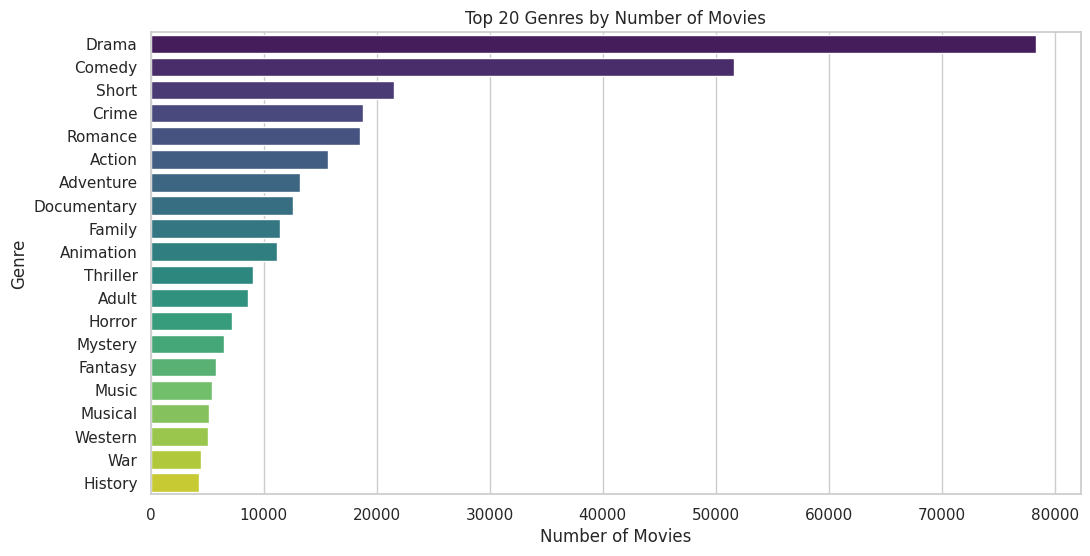

In [52]:
top_genres_pd = genre_count.limit(20).toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x="num_movies", y="genre", data=top_genres_pd, palette="viridis")
plt.title("Top 20 Genres by Number of Movies")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()


/tmp/ipython-input-3498604312.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_rating", y="genre", data=genre_avg_pd, palette="magma")


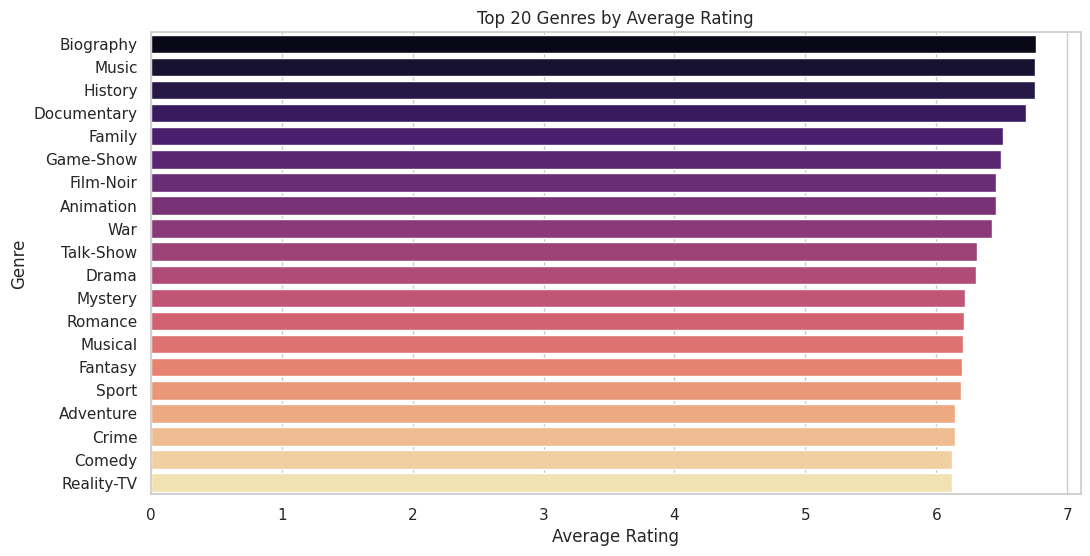

In [53]:
genre_avg_pd = genre_avg.limit(20).toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x="avg_rating", y="genre", data=genre_avg_pd, palette="magma")
plt.title("Top 20 Genres by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()


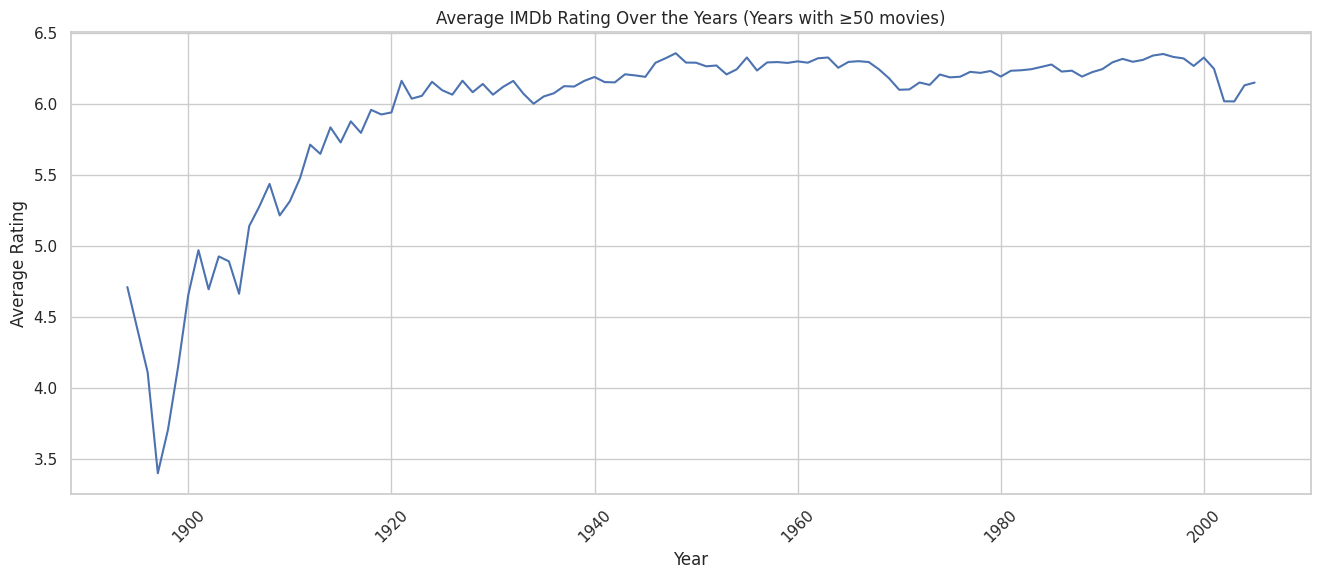

In [54]:
year_stats_pd = year_stats.filter(col("num_movies") >= 50).toPandas()

plt.figure(figsize=(16,6))
sns.lineplot(x="startYear", y="avg_rating", data=year_stats_pd)
plt.title("Average IMDb Rating Over the Years (Years with ≥50 movies)")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()


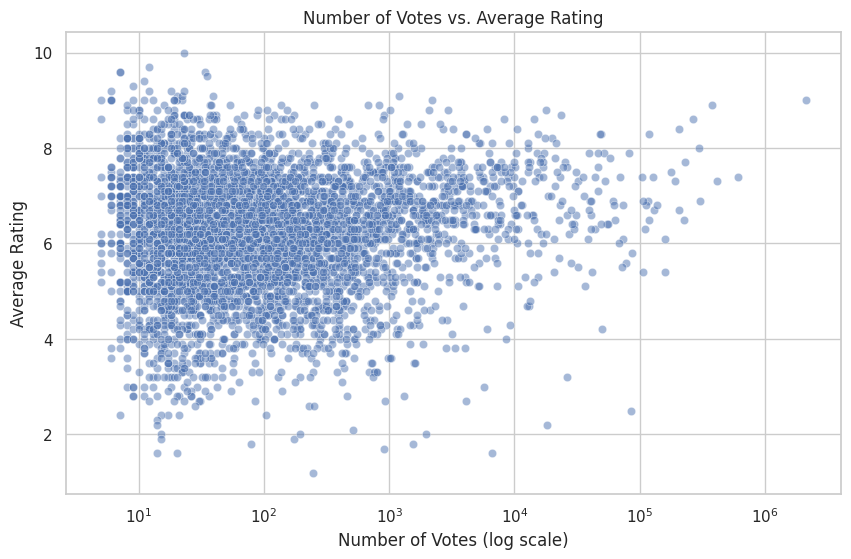

In [55]:
votes_rating_pd = df_clean.select("primaryTitle", "averageRating", "numVotes").toPandas().sample(5000, random_state=42)

plt.figure(figsize=(10,6))
sns.scatterplot(x="numVotes", y="averageRating", data=votes_rating_pd, alpha=0.5)
plt.xscale("log")
plt.title("Number of Votes vs. Average Rating")
plt.xlabel("Number of Votes (log scale)")
plt.ylabel("Average Rating")
plt.show()


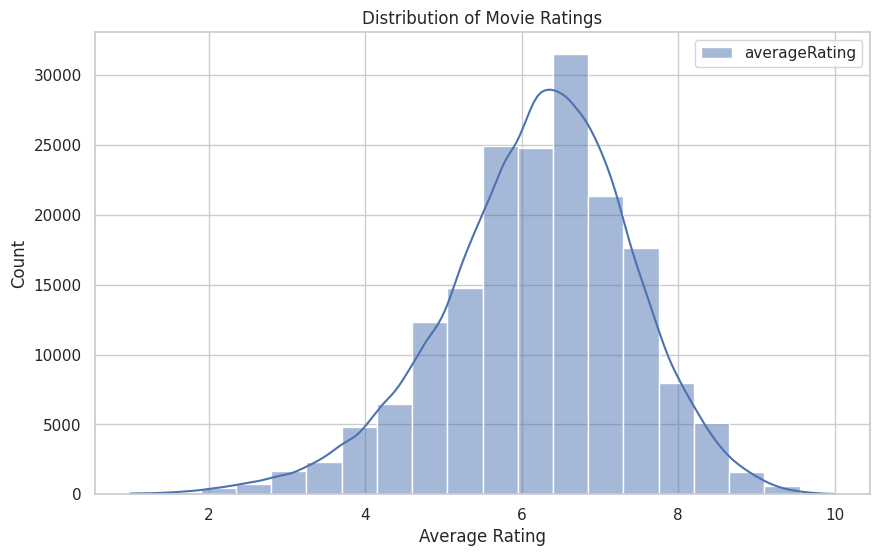

In [56]:
plt.figure(figsize=(10,6))
sns.histplot(df_clean.select("averageRating").toPandas(), bins=20, kde=True, color="skyblue")
plt.title("Distribution of Movie Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.show()


/tmp/ipython-input-3105262298.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="averageRating", y="primaryTitle", data=top_movies_pd, palette="coolwarm")


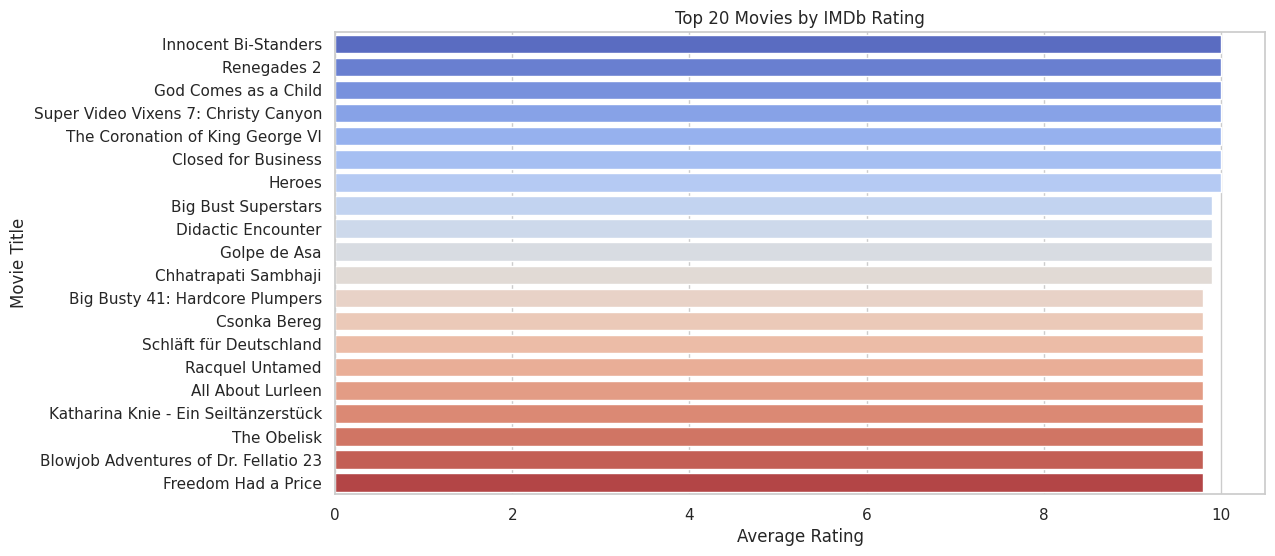

In [57]:
top_movies_pd = df_clean.select("primaryTitle", "averageRating").orderBy(col("averageRating").desc()).limit(20).toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x="averageRating", y="primaryTitle", data=top_movies_pd, palette="coolwarm")
plt.title("Top 20 Movies by IMDb Rating")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.show()